In [15]:


## Setup -----------------------------------------------------------------------
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

from tensorflow import keras
from tensorflow.python.ops.math_ops import Pow

#

from tensorflow.keras.layers import BatchNormalization, Dropout

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers import Lambda, Input, Dense, Concatenate
from keras.models import Model                                                  # Ok: se usa 230201
from keras.datasets import mnist
#from keras.losses import mse, binary_crossentropy

from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
mse = MeanSquaredError()
binary_crossentropy = BinaryCrossentropy()

from keras.utils import plot_model
from keras import backend as K
from keras import optimizers
from keras import layers

import numpy as np
import matplotlib as mplt
import matplotlib.pyplot as plt
import argparse
import os
import pickle

## Parameters -------------------------------------------------------------------
MIX = "AVERAGE"                                  # "MAX"


x_train(60k).shape:       (60000, 28, 28)
x_train_C.shape:     (55000, 28, 28, 1)
x_val_C.shape:     (5000, 28, 28, 1)
x_test_C.shape:      (10000, 28, 28, 1)
x_train.shape:       (55000, 784)
x_val.shape:       (5000, 784)
x_test.shape:       (10000, 784)
Xampliado.shape:     (55000, 794)
x_train_1.shape:    (55000, 784)
y_train_1.shape:      (55000, 10)
x_train_mix.shape:  (55000, 784)
x_test_1.shape:    (10000, 784)
y_test_1.shape:      (10000, 10)
x_test_mix.shape:  (10000, 784)
<KerasTensor shape=(None, 128), dtype=float32, sparse=False, ragged=False, name=z_sampling>
<KerasTensor shape=(None, 10), dtype=float32, sparse=False, ragged=False, name=decoder_condition>


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_115CL… │ (None, 794)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 128),     │    269,312 │ keras_tensor_115… │
│ (Functional)        │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_condition   │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_36      │ (None, 138)       │          0 │ encoder[1][2],    │
│ (Concatenate)       │                   │            │ decoder_conditio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 784)       │    237,072 │ concatenate_36[1… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 506,384 (1.93 MB)

 Trainable params: 506,384 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

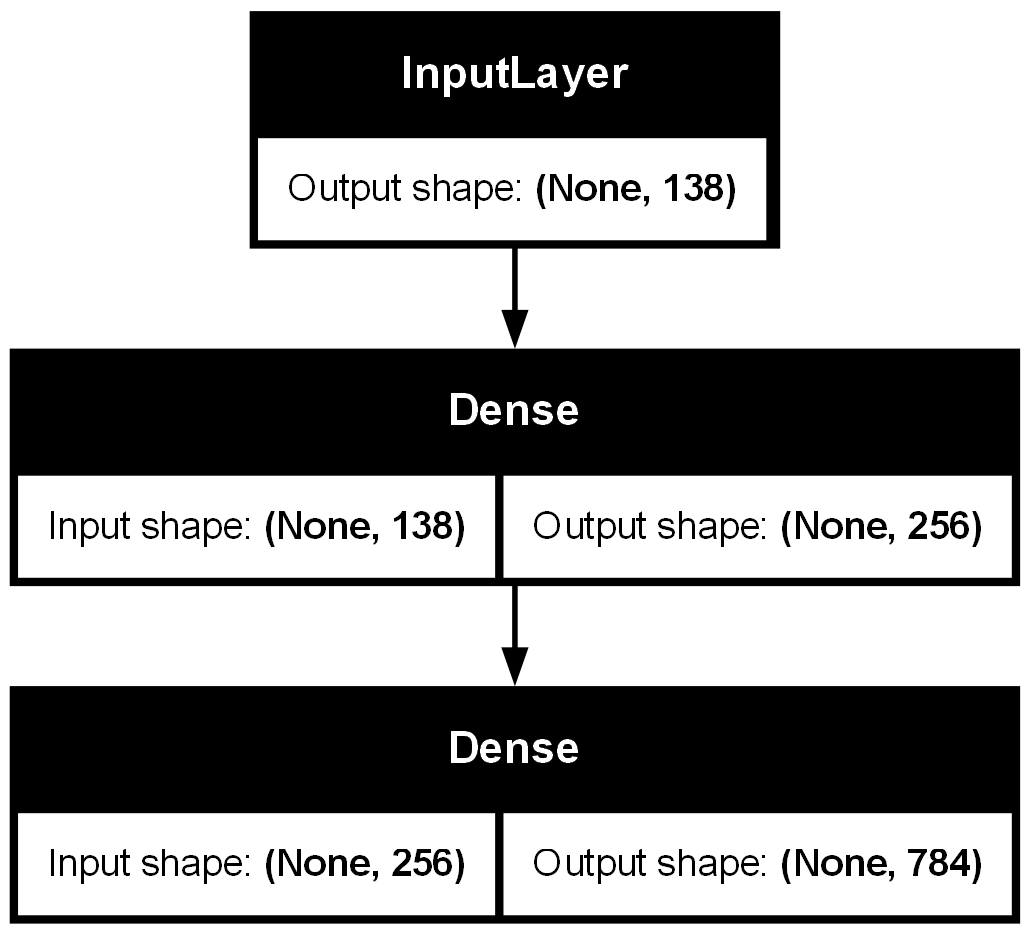

In [ ]:
## Data aquisition & Preprocessing ---------------------------------------------
# Agregado el validation set 240623

  # MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("x_train(60k).shape:      ", x_train.shape)

  # Normalization
image_size = x_train.shape[1]                                                   # 28
x_train = x_train.astype('float32') / 255                                       # [0, 1] imagnes re-escalada
x_test = x_test.astype('float32') / 255                                         # [0, 1]

  # Original individual images for Convolutional NN (28x28)
original_dim_C = image_size                                                     # 28
x_train_C = np.expand_dims(x_train, -1)
x_test_C = np.expand_dims(x_test, -1)
# Split training data into training and validation sets
x_train_C, x_val_C = x_train_C[:55000], x_train_C[55000:]
print("x_train_C.shape:    ", x_train_C.shape)
print("x_val_C.shape:    ", x_val_C.shape)
print("x_test_C.shape:     ", x_test_C.shape)

  # Flatten the individual images for Dense NN (784)
original_dim = image_size * image_size                                          # 784 cantidad de pixeles de la imagen
x_train = np.reshape(x_train, [-1, original_dim])                               # imagenes en 1D
x_test = np.reshape(x_test, [-1, original_dim])

y_train = tf.keras.utils.to_categorical(y_train)                                # one-hot
y_test = tf.keras.utils.to_categorical(y_test)                                  #
y_test_orig = y_test

# Split training data into training and validation sets
x_train, x_val = x_train[:55000], x_train[55000:]
y_train, y_val = y_train[:55000], y_train[55000:]

print("x_train.shape:      ", x_train.shape)
print("x_val.shape:      ", x_val.shape)
print("x_test.shape:      ", x_test.shape)

  # Ver para condicionar Convolutional  ******************************************

  # Para condicionar Dense (no se usa?)
Xampliado = Concatenate()([x_train,y_train])
print("Xampliado.shape:    ", Xampliado.shape)


## Superimposed digits - MAX
np.random.seed(3333)                                    #3333 Cambio el seed de 2022 (2024) para ver variabilidad   # de VAE 5 para fijar las pruebas y poder comparar
permrows = np.random.permutation(x_train.shape[0])
x_train_C_1 = x_train_C[permrows,:]                                               # alternative set for Convolutional
x_train_1 = x_train[permrows,:]                                               # alternative set for Dense
y_train_1 = y_train[permrows,:]
permrows = np.random.permutation(x_test.shape[0])
x_test_C_1 = x_test_C[permrows,:]                                               # alternative set for Convolutional
x_test_1 = x_test[permrows,:]                                               # alternative set for Dense
y_test_1 = y_test[permrows,:]

if MIX == "MAX":
  maximum_image = np.maximum(x_train,x_train_1)
  x_train_mix = maximum_image                                                    # Habilta para MAX - Inabilita para AVERAGE
  print("x_train_1.shape:   ", x_train_1.shape)
  print("y_train_1.shape:     ", y_train_1.shape)
  print("x_train_mix.shape: ", x_train_mix.shape)
  maximum_image = np.maximum(x_test,x_test_1)
  x_test_mix = maximum_image                                                    # Habilta para MAX - Inabilita para AVERAGE
  print("x_test_1.shape:   ", x_test_1.shape)
  print("y_test_1.shape:     ", y_test_1.shape)
  print("x_test_mix.shape: ", x_test_mix.shape)

## Superimposed digits - AVERAGE

if MIX == "AVERAGE":
  average_image = (x_train.astype(np.float32) + x_train_1.astype(np.float32)) / 2
  average_image = average_image.astype(np.uint8)  # Convert the pixel values back to uint8
  x_train_mix = average_image                                                      # Inhabilta para MAX - Habilita para AVERAGE
  print("x_train_1.shape:   ", x_train_1.shape)
  print("y_train_1.shape:     ", y_train_1.shape)
  print("x_train_mix.shape: ", x_train_mix.shape)
  average_image = (x_test.astype(np.float32) + x_test_1.astype(np.float32)) / 2
  average_image = average_image.astype(np.uint8)  # Convert the pixel values back to uint8
  x_test_mix = average_image                                                      # Inhabilta para MAX - Habilita para AVERAGE
  print("x_test_1.shape:   ", x_test_1.shape)
  print("y_test_1.shape:     ", y_test_1.shape)
  print("x_test_mix.shape: ", x_test_mix.shape)

#x_train: Imagenes escaladas 1D.
#y_train: Vector one-hot encoded.












#sampling layer
## Reparameterization trick ----------------------------------------------------

class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]                                                 # batch = number of data in the batch
    dim = tf.shape(z_mean)[1]                                                   # dim   = number of dimensions of "z"
      # by default, random_normal has mean=0 and std=1.0
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon


## Encoder ---------------------------------------------------------------------
  # network parameters
original_dim = np.shape(x_train)[1]
n_cond = np.shape(y_train)[1]                                                   # n_cond = 10 (number of conditions)
# n_cond = 0
                                                                     # input without conditions
#intermediate_dim = 512                   #256                         #128                 # 64
intermediate_dim = 256                                                          #128                 # 64
#intermediate_dim = 128                                                          # 64

#latent_dim = 256
latent_dim = 128                                                                #32                  # 2
#latent_dim = 32
#latent_dim = 2


  # Define encoder model -------------------------------------------------------
input_encoder = Input(shape=(original_dim,), name="input_encoder")
cond_encoder = Input(shape=(n_cond,), name="encoder_condition")
original_inputs = Concatenate()([input_encoder,cond_encoder])                   # se amplía la entrada "x" (784) con la condición "c" (10)

x = Dense(intermediate_dim, activation="relu")(original_inputs)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)

  # use reparameterization trick to push the sampling out as input
z = Sampling()((z_mean, z_log_var))                                             # (z_mean, z_log_var) is the tuple

encoder = Model(inputs=original_inputs, outputs=[z_mean, z_log_var, z], name="encoder")
#encoder.summary()

model_inputs = encoder.inputs

## Decoder ---------------------------------------------------------------------

n_cond = np.shape(y_train)[1]                                                   # n_cond = 10 (number of conditions) ¿se repite del encoder?

  # Define decoder model -------------------------------------------------------
z_inputs = Input(shape=(latent_dim,), name="z_sampling")
print(z_inputs)
cond_decoder = Input(shape=(n_cond,), name="decoder_condition")
print(cond_decoder)
latent_inputs = Concatenate()([z_inputs,cond_decoder])

x = Dense(intermediate_dim, activation="relu")(latent_inputs)
decoder_outputs = Dense(original_dim, activation="sigmoid")(x)

  # instantiate decoder model
decoder = Model(inputs=latent_inputs, outputs=decoder_outputs, name="decoder")
#decoder.summary()

## VAE Model -------------------------------------------------------------------

  # Define VAE model -------------------------------------------------------

original_inputs = Concatenate()([input_encoder,cond_encoder]) #¿Por que se vuelve a definir?
z_mean, z_log_var, z = encoder(original_inputs)
z_inputs = z

latent_inputs = Concatenate()([z_inputs,cond_decoder])
vae_outputs = decoder(latent_inputs)

  # instantiate VAE model
vae = Model(inputs=[original_inputs, cond_decoder], outputs=vae_outputs, name="vae")
vae.summary()

plot_model(decoder, show_shapes=True)


## Compile Loss and Optimizer

Beta = 1.                                                                       # Beta-VAE

  # Loss -----------------------------------------------------------------------
def vae_loss(y_true, y_pred):
   z_mean, z_log_var, z = encoder(original_inputs)

   kl_loss = -0.5 * (z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
   kl_loss = tf.reduce_sum(kl_loss, -1)

   mse = tf.keras.losses.MeanSquaredError()
   mse1 = mse(y_true, y_pred) * original_dim

     # Add KL divergence regularization loss.
   loss = mse1 + Beta * kl_loss
   return tf.reduce_mean(loss) #, axis=-1)

  # Optimizer ------------------------------------------------------------------
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

  # Compile --------------------------------------------------------------------
vae.compile(optimizer, loss=vae_loss)





input_encoder = x_train
cond_encoder = y_train
cond_decoder = y_train
estimated_output = x_train

input_encoder_val = x_val
cond_encoder_val = y_val
cond_decoder_val = y_val
estimated_output_val = x_val


original_inputs = Concatenate()([input_encoder, cond_encoder])
original_inputs_val = Concatenate()([input_encoder_val, cond_encoder_val])

print("Shapes of training inputs:")
print(f"original_inputs: {original_inputs.shape}")
#print(f"y_train: {y_train.shape}")
print("Shapes of validation inputs:")
print(f"original_inputs_val: {original_inputs_val.shape}")
#print(f"y_val: {y_val.shape}")

# Fit the model with early stopping and checkpoint callbacks
# Training
vae.fit(
    x=[original_inputs, cond_decoder],
    y=estimated_output,
    batch_size=128,
    epochs=5,
    validation_data=([original_inputs_val, cond_decoder_val], estimated_output_val)  # Use validation data
   #callbacks=[cp_callback, early_stopping]  # EarlyStopping to the list of callbacks
)


Modelo cVAE

<KerasTensor shape=(None, 128), dtype=float32, sparse=False, ragged=False, name=z_sampling>
<KerasTensor shape=(None, 10), dtype=float32, sparse=False, ragged=False, name=decoder_condition>


Shapes of training inputs:
original_inputs: (55000, 794)
Shapes of validation inputs:
original_inputs_val: (5000, 794)
Epoch 1/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 226s 522ms/step - loss: 65.6599 - val_loss: 40.4396
Epoch 2/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 222s 516ms/step - loss: 39.5660 - val_loss: 36.2619
Epoch 3/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 209s 486ms/step - loss: 36.1933 - val_loss: 34.6226
Epoch 4/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 207s 481ms/step - loss: 34.5644 - val_loss: 33.0922
Epoch 5/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 203s 471ms/step - loss: 33.1928 - val_loss: 31.7077


'\nvae.fit(\n    x=[original_inputs, cond_decoder],\n    y=estimated_output,\n    batch_size=128,\n    epochs=100,\n    #validation_data=([val_inputs, val_cond_decoder], val_estimated_output),  # Include validation data\n    #callbacks=[cp_callback, early_stopping]  # Add early_stopping to callbacks\n    callbacks=[cp_callback]\n)\n'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


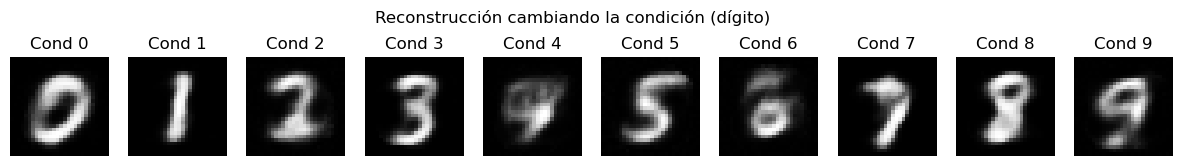

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

img = np.expand_dims(x_train[0], axis=0)
cond = np.expand_dims(y_train[0], axis=0)
Xampliado = Concatenate()([img, cond])
salida = vae.predict([Xampliado, cond])
reconstruccion = salida[0].reshape(28, 28)
plt.imshow(reconstruccion, cmap='gray')
plt.show()


# Selecciona una imagen de prueba
img = np.expand_dims(x_train[0], axis=0)

plt.figure(figsize=(15, 2))
for i in range(10):
    # Crea la condición one-hot para el dígito i
    cond = np.zeros((1, 10))
    cond[0, i] = 1

    # Predice usando la misma condición para encoder y decoder
    salida = vae.predict([Xampliado, cond])
    reconstruccion = salida[0].reshape(28, 28)

    plt.subplot(1, 10, i + 1)
    plt.imshow(reconstruccion, cmap='gray')
    plt.title(f"Cond {i}")
    plt.axis('off')

plt.suptitle("Reconstrucción cambiando la condición (dígito)")
plt.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------